Todo : get synthetic to work
 look at sythetic graph
 spot the difference

In [4]:
%cd ~/Dropbox/working-directory/UQ_Python
import scipy as sp
import scipy.sparse
import scipy.sparse.csgraph
import scipy.sparse.linalg
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 26

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels 
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


markers = ['o','*', 'v', '^', '<', '>', '8', 's', 'p', 'h']

from datasets.data_loaders_mlflow import load_MNIST
from datasets.Graph_manager import Graph_manager

/home/hao/Dropbox/working-directory/UQ_Python


/home/hao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  # Remove the CWD from sys.path while we load stuff.


# Compute base graph W.

Loading the MNIST data with digits [1, 4, 7] ...
Found MNIST data already saved



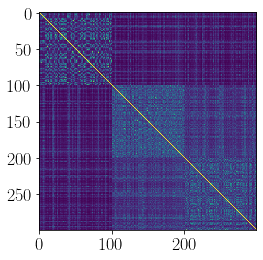

In [31]:
digits = [1,4,7]
num_points = [100]*3
seed = 42

data_params = {
    'digits' : digits,
    'num_points' : num_points,
    'seed' : seed
}

X, labels = load_MNIST(data_params)

gm = Graph_manager()
graph_params = {
    'knn': None,
    'Ltype': 'normed',
    'sigma': 1,
    'zp_k' : 15,
    'n_eigs': 300
}
W = gm.compute_similarity_graph(X, graph_params['knn'], graph_params['sigma'], graph_params['zp_k'])
plt.imshow(W.toarray())

# Tweak $\epsilon$ and compute the spectrum.

In [32]:
L = gm.compute_laplacian(W, graph_params['Ltype'])
w, v = gm.compute_spectrum(L, None)

N = sum(num_points)
K = len(num_points)

# Diagonal blocks
W0 = W.copy() 
idx = 0
for pts in num_points:
    W0[idx:idx + pts, idx + pts:] = 0
    W0[idx + pts:, idx:idx + pts] = 0
    L = sp.sparse.csgraph.laplacian(W0[idx:idx+pts, idx:idx+pts], normed=True)
    idx += pts

# off diagonal blocks
Wo = W - W0 
def get_eigs(eps):
    M = np.max(W)
    Wn = W0 + eps * Wo/M
    
    # make sure W is symmetric
    Wn += Wn.T
    Wn /= 2
    # remove diagonals
    Wn -= sp.sparse.diags(Wn.diagonal())
    L = sp.sparse.csgraph.laplacian(Wn, normed=True)
    [w, v] = sp.linalg.eigh(L.toarray())
    return w, v

In [33]:
num_in_each = 1
D0 = np.asarray(np.sum(W0, axis=1)).flatten()**0.5   # normalization for the 
fid = np.zeros(N, dtype='int')
u = np.zeros((N, K))
Chis = np.zeros((N, K))
idx = 0
for l in range(K):
    fid[idx:idx+num_in_each] = 1
    Chis[idx:idx+num_points[l],l] = D0[idx:idx+num_points[l]]/np.sqrt(num_points[l])
    Chis[idx:idx+num_points[l],l] /= sp.linalg.norm(Chis[idx:idx+num_points[l],l])
    idx += num_points[l]
labeled = np.nonzero(fid)
_, u = get_eigs(0)
u = u[:,:K] #@ np.random.randn(K, K)
# There is a order 1e-4 difference between eigenvectors of C_0
# and Chis, which screws up the numerics
# On purely synthetic data, the difference is 1e-16. 
# u = Chis#.dot(np.random.randn(K, K))
B = sp.sparse.diags(fid, format='csr')


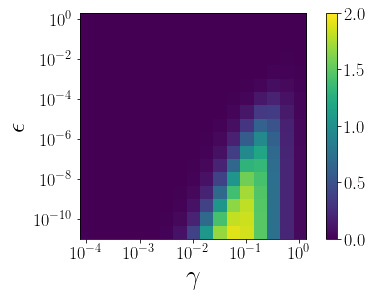

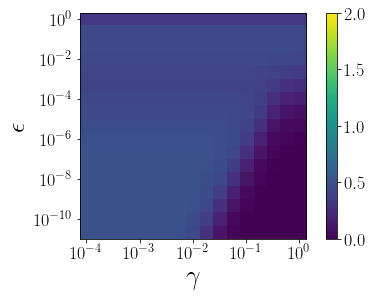

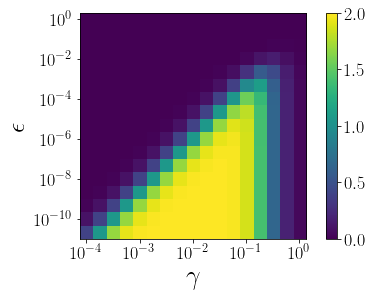

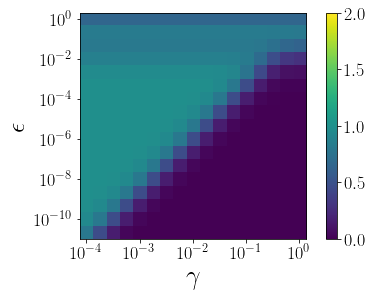

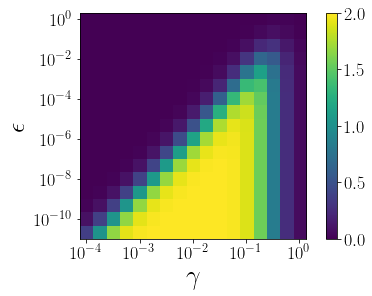

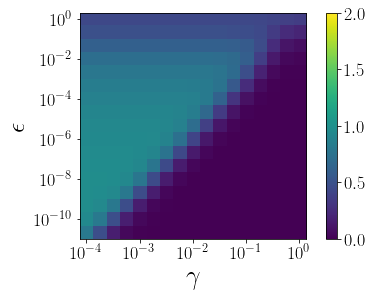

In [34]:
alphas = [0.5, 1, 5]
n_alpha = len(alphas)
n = 18
gammas = np.power(np.sqrt(0.2), range(n))
epss   = np.power(0.2, range(n))

TRC = np.zeros((n, n))
TRCBC = np.zeros((n, n))
BIAS = np.zeros((n, n))
I = np.zeros((n, n))

for ai, alpha in enumerate(alphas):
    for i, eps in enumerate(epss):
        w, v = get_eigs(eps)
        tau = (eps) ** (1/max(2, 2 * alpha)) 
        for j, gamma in enumerate(gammas):
            d = (tau ** (2 * alpha)) * np.power(w + tau**2., -alpha)
            d_inv = 1./d  
            prior_inv = v @ sp.sparse.diags(d_inv, format='csr') @ v.T
            # B/gamma^2
            B_over_gamma2 = B / (gamma * gamma)
            # post_inv  : (B/gamma^2 + C_{tau,\eps}^{-1})^{-1}
            post_inv  = prior_inv + B_over_gamma2
            # C^{-1}
            post = post_inv.I
            bias = sp.linalg.norm(post @ B_over_gamma2 @ u - u, ord='fro')

            #bias = sp.linalg.norm(post @ prior_inv @ u, ord='fro')
            BIAS[i,j] = bias ** 2

            trC = sp.trace(post)
            TRC[i,j] = trC

            post2 = post.dot(post)
            trCBC = sp.trace(post2[np.ix_(labeled[0], labeled[0])])
            TRCBC[i, j] = trCBC/(gamma**2.)

            I[i, j] = K * trC + K * trCBC + bias ** 2
            
    stride = 5
    fig = plt.figure()
    target = np.diff(np.log(I)) / np.diff(np.log(gammas))
    target = target[:-1, :]
    plt.imshow(np.flip(target, axis=1), cmap=plt.get_cmap('viridis'))
    plt.tight_layout()
    ax = plt.gca()
    plt.colorbar()
    plt.clim(0,2)
    ax.set_xticks(range(n-2, -1, -n//stride))
    ax.set_yticks(range(0, n-1, n//stride))
    ax.set_xticklabels([r'$10^{%i}$' % np.log10(x) for x in gammas[0:n:n//stride]])
    ax.set_yticklabels([r'$10^{%i}$' % np.log10(x) for x in epss[0:n:n//stride]])
    plt.xlabel(r'$\gamma$')
    plt.ylabel(r'$\epsilon$') 
    #plt.title(r'$\frac{\partial \log(\mathcal{I})}{\partial \log(\gamma)}$ with $\alpha$ = %2.1f'% alpha)
    fig.savefig('/home/hao/Dropbox/working-directory/uncertainty-quantification/figures/MNIST_dI_dgamma_alpha_{}.pdf'.format(alpha),
                bbox_inches="tight")
    # dI / d eps
    fig = plt.figure()
    target = np.diff(np.log(I), axis=0) / np.diff(np.log(epss)).reshape((-1,1))
    target = target[:, 1:]
    plt.imshow(np.flip(target, axis=1), cmap=plt.get_cmap('viridis'))
    plt.tight_layout()
    ax = plt.gca()
    plt.colorbar()
    plt.clim(0, 2)
    ax.set_xticks(range(n-2, -1, -n//stride))
    ax.set_yticks(range(0, n-1, n//stride))
    ax.set_xticklabels([r'$10^{%i}$' % np.log10(x) for x in gammas[0:n:n//stride]])
    ax.set_yticklabels([r'$10^{%i}$' % np.log10(x) for x in epss[0:n:n//stride]])
    
    #plt.title(r'$\frac{\partial \log(\mathcal{I})}{\partial \log(\epsilon)}$ with $\alpha$ = %2.1f'% alpha)
    plt.xlabel(r'$\gamma$')
    plt.ylabel(r'$\epsilon$')
    fig.savefig('/home/hao/Dropbox/working-directory/uncertainty-quantification/figures/MNIST_dI_deps_alpha_{}.pdf'.format(alpha),
                bbox_inches="tight")
    

In [36]:
print(X.shape)

(300, 784)


In [37]:
28  * 28

784